# CoNLL‑2003 Tokenization Analysis


This notebook adapts your IMDb pipeline to **CoNLL‑2003 (NER)** and runs the same tokenizer + TF‑IDF + Logistic Regression evaluation
by converting each sentence into text and assigning a **sentence‑level label**.

- Uses **Hugging Face `tokenizers`** (BPE / WordPiece / Unigram). No `sentencepiece` required.
- Loads CoNLL‑2003 from the dataset's **Parquet branch** (no remote loader script).
- Two labeling modes:
  - `contains_entity` (binary): 1 if any token has a named-entity tag, else 0.
  - `major_entity` (multi‑class): the dominant entity type among {PER, ORG, LOC, MISC}, or NONE.

Run cells top‑to‑bottom.

In [15]:
# --- Parameters ---
# Dataset & labeling
DATASET_NAME = "eriktks/conll2003"
LABEL_MODE   = "contains_entity"   # or: "major_entity"

# Output files for this dataset
CORPUS_PATH  = "corpus/conll2003_corpus.txt"
CSV_PATH     = f"data/conll2003_{LABEL_MODE}.csv"

# Tokenizer choice (HF only; no SentencePiece required)
MODEL_TYPE   = "unigram"           # "unigram" | "bpe" | "wordpiece"
VOCAB_SIZE   = 10000
TOK_PATH     = f"tokenizers/{MODEL_TYPE}-conll2003-{VOCAB_SIZE//1000}k.json"

# Analysis config
TEST_SIZE    = 0.20
RANDOM_SEED  = 42
TYPO_PROB    = 0.05


In [16]:
import os
for d in ["data", "corpus", "tokenizers", "results", "logs"]:
    os.makedirs(d, exist_ok=True)
print("Ensured directories:", ", ".join(d for d in ["data", "corpus", "tokenizers", "results", "logs"]))


Ensured directories: data, corpus, tokenizers, results, logs


## Step 1 — Prepare CoNLL‑2003 into corpus + labeled CSV


In [17]:
# Step 1 — Prepare CoNLL‑2003 (from Parquet branch; no loader script)
from datasets import load_dataset
import pandas as pd, os
from collections import Counter

def _hf_hub_parquet_paths(repo="eriktks/conll2003", revision="refs/convert/parquet"):
    # Prefer hf:// protocol; fallback to HTTPS resolve URLs if needed
    base_hf = f"hf://datasets/{repo}@{revision}/conll2003"
    base_https = "https://huggingface.co/datasets/" + repo + "/resolve/" + revision.replace("/", "%2F") + "/conll2003"
    return {
        "hf": {
            "train":      f"{base_hf}/train/*.parquet",
            "validation": f"{base_hf}/validation/*.parquet",
            "test":       f"{base_hf}/test/*.parquet",
        },
        "https": {
            "train":      f"{base_https}/train/0000.parquet",
            "validation": f"{base_https}/validation/0000.parquet",
            "test":       f"{base_https}/test/0000.parquet",
        },
    }

def _infer_O_index(seq_iterable):
    # Choose the most frequent tag id across ner_tags as 'O' (works for CoNLL-2003)
    cnt = Counter()
    for seq in seq_iterable:
        cnt.update(seq)
    o_idx, _ = cnt.most_common(1)[0]
    return o_idx

def prepare_conll2003(corpus_path: str, csv_path: str, label_mode: str = "contains_entity"):
    """
    Build:
      - corpus_path: one sentence per line (tokens joined by spaces)
      - csv_path: dataframe with columns [text, label] for sentence-level classification

    label_mode:
      - "contains_entity": 1 if any NE tag is not 'O', else 0
      - "major_entity": one of {NONE, PER, ORG, LOC, MISC} -> ints 0..4 (requires label names)
    """
    paths = _hf_hub_parquet_paths()

    # Try hf:// uris (supports wildcards). Fallback to HTTPS resolve URLs.
    try:
        ds = load_dataset(
            "parquet",
            data_files={
                "train":      paths["hf"]["train"],
                "validation": paths["hf"]["validation"],
                "test":       paths["hf"]["test"],
            },
        )
    except Exception:
        ds = load_dataset(
            "parquet",
            data_files={
                "train":      paths["https"]["train"],
                "validation": paths["https"]["validation"],
                "test":       paths["https"]["test"],
            },
        )

    # Get label names if present (Sequence(ClassLabel))
    label_names = None
    try:
        label_feature = ds["train"].features["ner_tags"].feature
        label_names = getattr(label_feature, "names", None)
    except Exception:
        label_names = None

    # Determine 'O' id
    if label_names is not None and "O" in label_names:
        O_IDX = label_names.index("O")
    else:
        O_IDX = _infer_O_index(ds["train"]["ner_tags"])

    rows_text, rows_label = [], []

    if label_mode not in {"contains_entity", "major_entity"}:
        raise ValueError("label_mode must be 'contains_entity' or 'major_entity'")

    for split in ["train", "validation", "test"]:
        tokens_list = ds[split]["tokens"]
        tags_list   = ds[split]["ner_tags"]
        for tokens, ner_ids in zip(tokens_list, tags_list):
            text = " ".join(tokens)

            if label_mode == "contains_entity":
                label = 1 if any(tid != O_IDX for tid in ner_ids) else 0
            else:  # major_entity
                if label_names is None:
                    raise RuntimeError(
                        "major_entity requires label names in dataset features. "
                        "Use label_mode='contains_entity' or another CoNLL version with names."
                    )
                counts = Counter()
                for tid in ner_ids:
                    tag = label_names[tid]
                    if tag != "O":
                        etype = tag.split("-", 1)[1]  # PER/ORG/LOC/MISC
                        counts[etype] += 1
                label_text = max(counts, key=counts.get) if counts else "NONE"
                label_map = {"NONE": 0, "PER": 1, "ORG": 2, "LOC": 3, "MISC": 4}
                label = label_map[label_text]

            rows_text.append(text)
            rows_label.append(label)

    # Save CSV
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    pd.DataFrame({"text": rows_text, "label": rows_label}).to_csv(csv_path, index=False, encoding="utf-8")
    print(f"Wrote {csv_path} with {len(rows_text)} sentences.")

    # Save raw corpus
    os.makedirs(os.path.dirname(corpus_path), exist_ok=True)
    with open(corpus_path, "w", encoding="utf-8") as f:
        for t in rows_text:
            f.write(t + "\n")
    print(f"Wrote {corpus_path}.")


In [18]:
# Run Step 1
prepare_conll2003(CORPUS_PATH, CSV_PATH, label_mode=LABEL_MODE)


Wrote data/conll2003_contains_entity.csv with 20744 sentences.
Wrote corpus/conll2003_corpus.txt.


## Step 2 — Train a tokenizer (HF `tokenizers`)


In [19]:
# Train tokenizer (HF `tokenizers`: BPE / WordPiece / Unigram)
import os
from tokenizers import Tokenizer as HFTokenizer
from tokenizers.models import BPE, WordPiece, Unigram
from tokenizers.trainers import BpeTrainer, WordPieceTrainer, UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFD, Lowercase, StripAccents, Sequence as NormalizerSequence

def train_tokenizer_hf(model_type: str, corpus_file: str, output_path: str, vocab_size: int = 10000):
    if not os.path.exists(corpus_file):
        raise FileNotFoundError(f"Corpus not found: {corpus_file}")

    mt = model_type.lower()
    if mt not in {"bpe", "wordpiece", "unigram"}:
        raise ValueError("model_type must be one of: 'bpe', 'wordpiece', 'unigram'")

    if mt == "bpe":
        model = BPE(unk_token="[UNK]")
        trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
    elif mt == "wordpiece":
        model = WordPiece(unk_token="[UNK]")
        trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
    else:  # unigram
        model = Unigram()
        trainer = UnigramTrainer(vocab_size=vocab_size, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

    tok = HFTokenizer(model)
    # Normalization similar to earlier project
    tok.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])
    tok.pre_tokenizer = Whitespace()

    os.makedirs(os.path.dirname(output_path) or ".", exist_ok=True)
    tok.train([corpus_file], trainer)
    tok.save(output_path)
    print(f"Saved tokenizer to: {output_path}")


In [20]:
# Run Step 2
train_tokenizer_hf(MODEL_TYPE, CORPUS_PATH, TOK_PATH, VOCAB_SIZE)
print("Tokenizer saved to:", TOK_PATH)


Saved tokenizer to: tokenizers/unigram-conll2003-10k.json
Tokenizer saved to: tokenizers/unigram-conll2003-10k.json


## Step 3 — Run the analysis (Zipf + TF‑IDF + Logistic Regression)


In [ ]:
# Analysis — Zipf + TF‑IDF + Logistic Regression (SentencePiece optional for .model files)
import os, re, random, string, csv
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Couldn't install sentencepiece on my machine - used only if a .model tokenizer is passed
try:
    import sentencepiece as spm
except Exception:
    spm = None

from tokenizers import Tokenizer as HFTokenizer

def sanitize_name(path: str) -> str:
    base = os.path.basename(path)
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", os.path.splitext(base)[0])

def load_tokenizer_any(tokenizer_path: str):
    """
    Load either an HF Tokenizer (.json) or a SentencePiece model (.model).
    Returns (encode_to_tokens_fn, vocab_tokens, kind) where kind in {"hf","sp"}.
    """
    if tokenizer_path.endswith(".model"):
        if spm is None:
            raise ImportError("This is a SentencePiece .model. Install `sentencepiece` or use an HF .json tokenizer.")
        sp = spm.SentencePieceProcessor(model_file=tokenizer_path)
        vocab_tokens = [sp.id_to_piece(i) for i in range(sp.vocab_size())]
        def enc(text: str): return sp.encode(text, out_type=str)
        return enc, vocab_tokens, "sp"

    # HF tokenizer (.json) — no sentencepiece needed
    tok = HFTokenizer.from_file(tokenizer_path)
    vocab = tok.get_vocab()  # dict token -> id
    vocab_tokens = [t for t, i in sorted(vocab.items(), key=lambda kv: kv[1])]
    def enc(text: str): return tok.encode(text).tokens
    return enc, vocab_tokens, "hf"

def make_results_dir():
    os.makedirs("results", exist_ok=True)

def tokens_for_texts(encode_fn, texts):
    # Return pre-tokenized strings (space-delimited) for TF-IDF
    return [" ".join(encode_fn(t)) for t in texts]

def add_typos(s: str, p: float = 0.05, letters: str = string.ascii_lowercase):
    # ~5% random character substitutions on alphabetic chars
    out = []
    for ch in s:
        if ch.isalpha() and random.random() < p: out.append(random.choice(letters))
        else: out.append(ch)
    return "".join(out)

def plot_zipf(token_lists, save_path: str, title: str):
    # token_lists: list[list[str]]
    freq = Counter(t for toks in token_lists for t in toks)
    if not freq:
        print("No tokens to plot Zipf."); return
    counts = np.array(sorted(freq.values(), reverse=True), dtype=np.float64)
    ranks  = np.arange(1, len(counts) + 1, dtype=np.float64)

    plt.figure()
    plt.loglog(ranks, counts)
    plt.xlabel("Rank"); plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout(); plt.savefig(save_path, dpi=160); plt.close()
    print(f"Saved Zipf plot -> {save_path}")

def run_full_analysis(tokenizer_path: str, data_path: str,
                      test_size=0.2, random_state=42, typo_prob=0.05):
    make_results_dir()
    random.seed(random_state)

    name        = sanitize_name(tokenizer_path)
    report_txt  = os.path.join("results", f"classification_report_{name}.txt")
    zipf_png    = os.path.join("results", f"zipf_plot_{name}.png")
    results_csv = os.path.join("results", "full_results.csv")

    encode_fn, vocab_tokens, kind = load_tokenizer_any(tokenizer_path)
    print(f"Loaded tokenizer kind={kind}, vocab size={len(vocab_tokens)}")

    # Load labeled data
    df = pd.read_csv(data_path)
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"].tolist(), df["label"].tolist(),
        test_size=test_size, random_state=random_state, stratify=df["label"]
    )

    # Zipf on training tokens
    tok_lists_for_zipf = [encode_fn(t) for t in X_train]
    plot_zipf(tok_lists_for_zipf, zipf_png, f"Zipf — {name} (|V|={len(vocab_tokens)})")

    # Pre-tokenize (space-delimited strings)
    X_train_tok = tokens_for_texts(encode_fn, X_train)
    X_test_tok  = tokens_for_texts(encode_fn, X_test)

    # Noisy test set: inject character typos BEFORE re-tokenizing
    X_test_noisy_txt = [add_typos(t, p=typo_prob) for t in X_test]
    X_test_noisy_tok = tokens_for_texts(encode_fn, X_test_noisy_txt)

    # TF-IDF with a FIXED vocabulary = tokenizer's tokens
    vocab_map = {tok: i for i, tok in enumerate(vocab_tokens)}
    vectorizer = TfidfVectorizer(
        vocabulary=vocab_map,
        tokenizer=str.split,
        preprocessor=None,
        token_pattern=None,
        lowercase=False,
        ngram_range=(1, 1),
    )

    Xtr = vectorizer.fit_transform(X_train_tok)
    Xte = vectorizer.transform(X_test_tok)
    Xte_noisy = vectorizer.transform(X_test_noisy_tok)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(Xtr, y_train)

    y_pred_clean = clf.predict(Xte)
    y_pred_noisy = clf.predict(Xte_noisy)

    clean_acc = accuracy_score(y_test, y_pred_clean)
    noisy_acc = accuracy_score(y_test, y_pred_noisy)
    drop_pct  = max(0.0, (clean_acc - noisy_acc) * 100.0)

    # Save detailed reports
    rep_clean = classification_report(y_test, y_pred_clean, digits=4)
    rep_noisy = classification_report(y_test, y_pred_noisy, digits=4)
    with open(report_txt, "w", encoding="utf-8") as f:
        f.write(f"Tokenizer: {name}\nVocab size: {len(vocab_tokens)}\n\n")
        f.write("=== CLEAN ===\n" + rep_clean + "\n\n")
        f.write("=== NOISY ===\n" + rep_noisy + "\n")
    print(f"Wrote report -> {report_txt}")

    # Append summary CSV
    write_hdr = not os.path.exists(results_csv)
    with open(results_csv, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        if write_hdr:
            w.writerow(["Tokenizer", "Vocab", "Clean Acc", "Noisy Acc", "Drop (%)"])
        w.writerow([name, len(vocab_tokens),
                    round(clean_acc, 4), round(noisy_acc, 4), round(drop_pct, 2)])
    print(f"Appended results -> {results_csv}")
    print({"Tokenizer": name, "Vocab": len(vocab_tokens), "Clean Acc": clean_acc,
           "Noisy Acc": noisy_acc, "Drop (%)": drop_pct})


In [22]:
# Run Step 3
run_full_analysis(
    tokenizer_path=TOK_PATH,   # .json from Step 2
    data_path=CSV_PATH,        # CSV from Step 1
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    typo_prob=TYPO_PROB
)


Loaded tokenizer kind=hf, vocab size=9374
Saved Zipf plot -> results\zipf_plot_unigram-conll2003-10k.png
Wrote report -> results\classification_report_unigram-conll2003-10k.txt
Appended results -> results\full_results.csv
{'Tokenizer': 'unigram-conll2003-10k', 'Vocab': 9374, 'Clean Acc': 0.8864786695589298, 'Noisy Acc': 0.8532176428054953, 'Drop (%)': 3.3261026753434564}


## Step 4 — Visualize aggregate results


In [23]:
# Visualize final charts
import os, pandas as pd
import matplotlib.pyplot as plt

def visualize_results(csv_path="results/full_results.csv"):
    if not os.path.exists(csv_path):
        print(f"No results CSV found at {csv_path}. Run the analysis first."); return
    df = pd.read_csv(csv_path).sort_values("Clean Acc", ascending=False)

    # Bar: Clean vs Noisy
    plt.figure()
    idx = range(len(df))
    plt.bar([i - 0.2 for i in idx], df["Clean Acc"], width=0.4, label="Clean")
    plt.bar([i + 0.2 for i in idx], df["Noisy Acc"], width=0.4, label="Noisy")
    plt.xticks(list(idx), df["Tokenizer"], rotation=30, ha="right")
    plt.ylabel("Accuracy")
    plt.title("CoNLL-2003 — Accuracy (Clean vs Noisy)")
    plt.legend()
    plt.tight_layout()
    os.makedirs("results", exist_ok=True)
    out1 = "results/final_performance_chart.png"
    plt.savefig(out1, dpi=160); plt.close()
    print(f"Saved {out1}")

    # Bar: Drop (%)
    plt.figure()
    plt.bar(list(idx), df["Drop (%)"])
    plt.xticks(list(idx), df["Tokenizer"], rotation=30, ha="right")
    plt.ylabel("Drop (%)")
    plt.title("CoNLL-2003 — Robustness (Accuracy Drop)")
    plt.tight_layout()
    out2 = "results/robustness_drop_chart.png"
    plt.savefig(out2, dpi=160); plt.close()
    print(f"Saved {out2}")

# Run Step 4
visualize_results()


Saved results/final_performance_chart.png
Saved results/robustness_drop_chart.png


## Compare Unigram, BPE, WordPiece quickly


In [24]:
import os
for mt in ["unigram", "bpe", "wordpiece"]:
    tok_path = f"tokenizers/{mt}-conll2003-{VOCAB_SIZE//1000}k.json"
    if not os.path.exists(tok_path):
        train_tokenizer_hf(mt, CORPUS_PATH, tok_path, VOCAB_SIZE)
    run_full_analysis(
        tokenizer_path=tok_path,
        data_path=CSV_PATH,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED,
        typo_prob=TYPO_PROB
    )
visualize_results()


Loaded tokenizer kind=hf, vocab size=9374
Saved Zipf plot -> results\zipf_plot_unigram-conll2003-10k.png
Wrote report -> results\classification_report_unigram-conll2003-10k.txt
Appended results -> results\full_results.csv
{'Tokenizer': 'unigram-conll2003-10k', 'Vocab': 9374, 'Clean Acc': 0.8864786695589298, 'Noisy Acc': 0.8532176428054953, 'Drop (%)': 3.3261026753434564}
Saved tokenizer to: tokenizers/bpe-conll2003-10k.json
Loaded tokenizer kind=hf, vocab size=10000
Saved Zipf plot -> results\zipf_plot_bpe-conll2003-10k.png
Wrote report -> results\classification_report_bpe-conll2003-10k.txt
Appended results -> results\full_results.csv
{'Tokenizer': 'bpe-conll2003-10k', 'Vocab': 10000, 'Clean Acc': 0.8768377922390937, 'Noisy Acc': 0.8479151602795855, 'Drop (%)': 2.8922631959508283}
Saved tokenizer to: tokenizers/wordpiece-conll2003-10k.json
Loaded tokenizer kind=hf, vocab size=10000
Saved Zipf plot -> results\zipf_plot_wordpiece-conll2003-10k.png
Wrote report -> results\classification_r

### 🏁 Scoreboard (`results/full_results.csv`) — sorted by Clean Acc

,Tokenizer,Vocab,Clean Acc,Noisy Acc,Drop (%)
0,unigram-conll2003-10k,9374,0.8865,0.8532,3.33
1,unigram-conll2003-10k,9374,0.8865,0.8532,3.33
2,bpe-conll2003-10k,10000,0.8768,0.8479,2.89
3,wordpiece-conll2003-10k,10000,0.8768,0.8455,3.13


---
### 🔎 Details for run: `wordpiece-conll2003-10k`

**Summary row for this tokenizer:**

,Tokenizer,Vocab,Clean Acc,Noisy Acc,Drop (%)
0,wordpiece-conll2003-10k,10000,0.8768,0.8455,3.13


**Zipf plot**

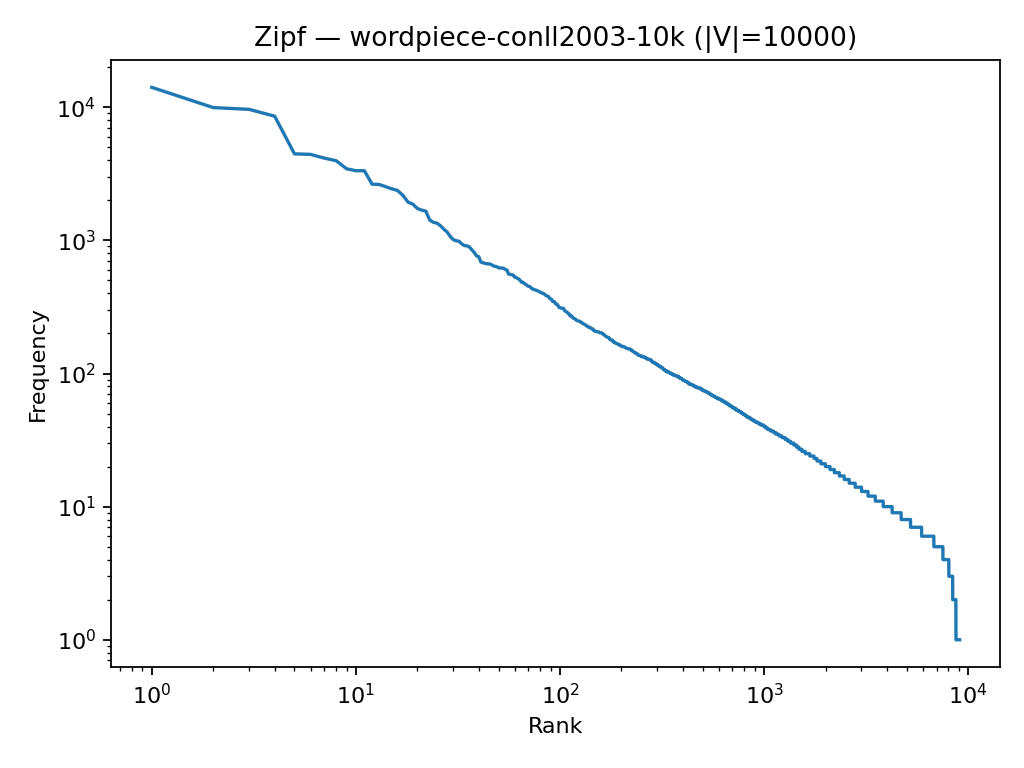

**Clean vs Noisy Accuracy**

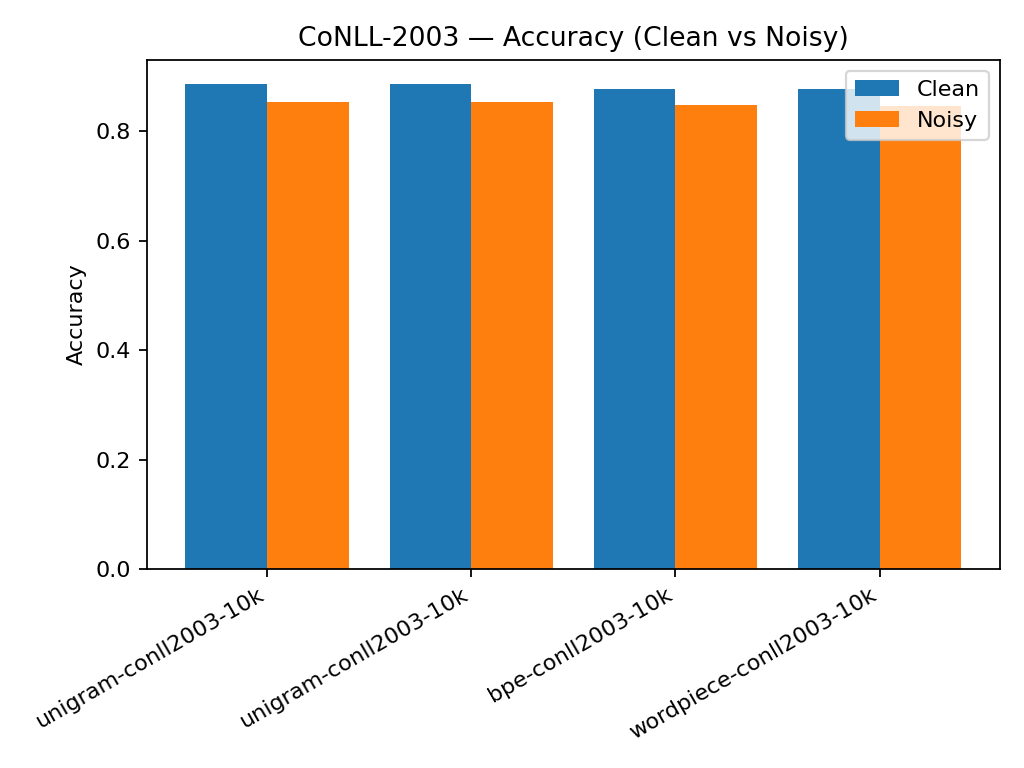

**Accuracy drop (%)**

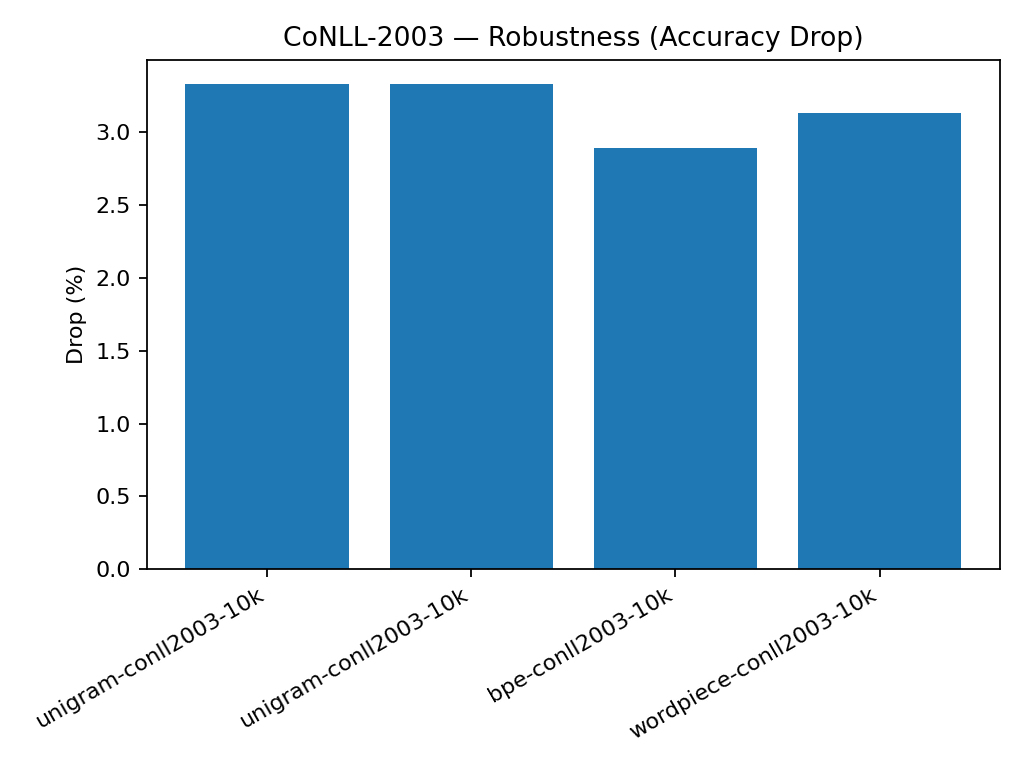

**Classification report**

```
Tokenizer: wordpiece-conll2003-10k
Vocab size: 10000

=== CLEAN ===
              precision    recall  f1-score   support

           0     0.8879    0.4565    0.6030       850
           1     0.8755    0.9851    0.9271      3299

    accuracy                         0.8768      4149
   macro avg     0.8817    0.7208    0.7650      4149
weighted avg     0.8781    0.8768    0.8607      4149


=== NOISY ===
              precision    recall  f1-score   support

           0     0.9372    0.2635    0.4114       850
           1     0.8399    0.9955    0.9111      3299

    accuracy                         0.8455      4149
   macro avg     0.8886    0.6295    0.6612      4149
weighted avg     0.8598    0.8455    0.8087      4149


```

In [26]:
# Output
from pathlib import Path
import pandas as pd
from IPython.display import display, Markdown, Image
import glob, os

RESULTS_DIR = Path("results")

SELECT_TOKENIZER = None

def latest_file(pattern: str):
    files = sorted(glob.glob(str(RESULTS_DIR / pattern)), key=os.path.getmtime)
    return files[-1] if files else None

# Scoreboard
scoreboard_path = RESULTS_DIR / "full_results.csv"
if scoreboard_path.exists():
    df = pd.read_csv(scoreboard_path)
    display(Markdown("### 🏁 Scoreboard (`results/full_results.csv`) — sorted by Clean Acc"))
    display(df.sort_values("Clean Acc", ascending=False).reset_index(drop=True))
else:
    display(Markdown("_No scoreboard yet. Run the analysis cell (Step 3) to populate it._"))
    df = None

# Determine which run to show details for
name = SELECT_TOKENIZER
if name is None:
    rep = latest_file("classification_report_*.txt")
    if rep:
        name = Path(rep).stem.replace("classification_report_", "")

if not name:
    display(Markdown("_No classification reports found yet. Run Step 3 to generate results._"))
else:
    display(Markdown(f"---\n### 🔎 Details for run: `{name}`"))

    # If we have a scoreboard row for this tokenizer, show it
    if df is not None and "Tokenizer" in df.columns:
        row = df[df["Tokenizer"] == name]
        if not row.empty:
            display(Markdown("**Summary row for this tokenizer:**"))
            display(row.reset_index(drop=True))
        else:
            display(Markdown("_This tokenizer is not in the scoreboard (yet)._"))

    # Show images: Zipf and aggregate charts
    zipf_path = RESULTS_DIR / f"zipf_plot_{name}.png"
    if zipf_path.exists():
        display(Markdown("**Zipf plot**"))
        display(Image(filename=str(zipf_path)))
    else:
        z_latest = latest_file("zipf_plot_*.png")
        if z_latest:
            display(Markdown("**Zipf plot (latest available)**"))
            display(Image(filename=z_latest))

    perf_path = RESULTS_DIR / "final_performance_chart.png"
    if perf_path.exists():
        display(Markdown("**Clean vs Noisy Accuracy**"))
        display(Image(filename=str(perf_path)))

    drop_path = RESULTS_DIR / "robustness_drop_chart.png"
    if drop_path.exists():
        display(Markdown("**Accuracy drop (%)**"))
        display(Image(filename=str(drop_path)))

    # Show classification report text
    rep_path = RESULTS_DIR / f"classification_report_{name}.txt"
    if not rep_path.exists():
        rep_path = latest_file("classification_report_*.txt")
        if rep_path:
            display(Markdown("_Exact report not found; showing latest available._"))

    if rep_path and Path(rep_path).exists():
        display(Markdown("**Classification report**"))
        with open(rep_path, encoding="utf-8") as f:
            display(Markdown(f"```\n{f.read()}\n```"))
    else:
        display(Markdown("_No classification report file found._"))
